# Tutorial on "Graph Neural Networks from Scratch"

### Necessary imports

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

## 1. Loading the graph

We will use [Zachary's Karate Club]("https://en.wikipedia.org/wiki/Zachary%27s_karate_club").
 
This is one of the most popular benchmark datasets for problems related to community stucture and detection.
The dataset was proposed in ["An Information Flow Model for Conflict and Fission in Small Groups"](https://www.journals.uchicago.edu/doi/10.1086/jar.33.4.3629752) by Wayne W. Zachary.

By the legend, after an argument between the instructor('Mr. Hi') and the administrator('Officer'), the karate club broke into two.Therefore, each node is labeled either 'Mr. Hi' or 'Officer'.

In [2]:
G = nx.karate_club_graph()

In [3]:
number_of_nodes = G.number_of_nodes()
number_of_edges = G.number_of_edges()
print(f"G is undirected graph with {number_of_nodes} and {number_of_edges} edges.")

G is undirected graph with 34 and 78 edges.


In [4]:
def get_binary_labels(graph):
    labels_dict = nx.get_node_attributes(graph, 'club')
    labels = [0 if v == 'Mr. Hi' else 1 for _, v in labels_dict.items()]
    return labels

In [5]:
def draw_graph(graph):
    binary_labels = get_binary_labels(graph)
    nx.draw(graph, node_color=binary_labels, cmap=plt.cm.plasma)

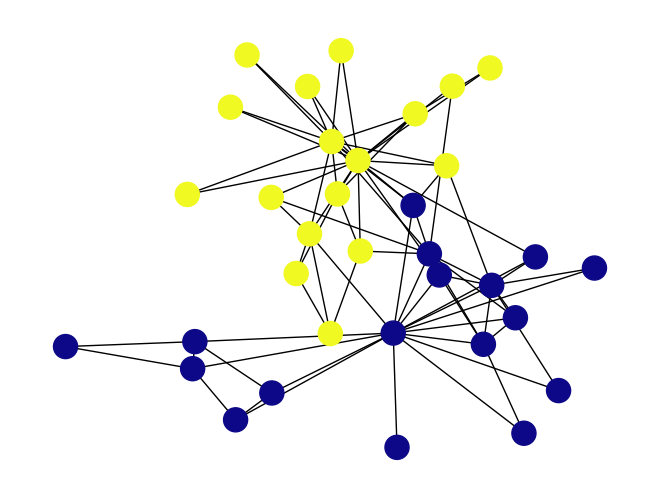

In [6]:
draw_graph(G)

So this was the visual representation of the graph. Now let us get **adjacency matrix** for this graph.

**Adjacency matrix** is another form of graph representation which is more useful for computational purposes. 
[i,j] elemnt of this matrix is zero if there is no connection between i-th and j-th nodes, else we put some value *(1 for example)*. See more information [here](https://en.wikipedia.org/wiki/Adjacency_matrix).

In [7]:
A = nx.adjacency_matrix(G)
A

<34x34 sparse array of type '<class 'numpy.int64'>'
	with 156 stored elements in Compressed Sparse Row format>

The result is a sparse matrix because we have only 78 connections out of 561 possible connections in the graph. Let us convert it to regular numpy array.

In [8]:
A_numpy = A.toarray()
A_numpy

array([[0, 4, 5, ..., 2, 0, 0],
       [4, 0, 6, ..., 0, 0, 0],
       [5, 6, 0, ..., 0, 2, 0],
       ...,
       [2, 0, 0, ..., 0, 4, 4],
       [0, 0, 2, ..., 4, 0, 5],
       [0, 0, 0, ..., 4, 5, 0]])

## 2. Message passing
In this tutorial we will implement the concept of message passing via matrix multiplication.
Also we recommend to see the [video](https://www.youtube.com/watch?v=ijmxpItkRjc) that briefly describes the concept of message passing and provides good visualizations.

**In this section of the tutorial let us examine a small example to understand underlying concepts to apply them further in the GCN layer.** 

Let us have an undirected graph with 6 nodes. And each node will have a numerical feature with value from 1 to 5 (*some rating value for example*) 

In [9]:
# Given binary adjacency matrix
A_example = np.array(
    [
        [0, 1, 0, 0, 1, 0],
        [1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 0],
        [0, 0, 1, 0, 1, 1],
        [1, 1, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0],
    ]
)

# Construct a graph from binary adjacency matrix
G_example = nx.from_numpy_array(A_example)
print(f"G_example is undirected graph with {G_example.number_of_nodes()} and {G_example.number_of_edges()} edges.")

# Initialize node features
node_features = {i: {"feature": np.random.randint(1, 5 + 1)} for i in range(G_example.number_of_nodes())}
nx.set_node_attributes(G_example, node_features)
print("node features:")
print(node_features)

G_example is undirected graph with 6 and 7 edges.
node features:
{0: {'feature': 4}, 1: {'feature': 3}, 2: {'feature': 4}, 3: {'feature': 3}, 4: {'feature': 5}, 5: {'feature': 2}}


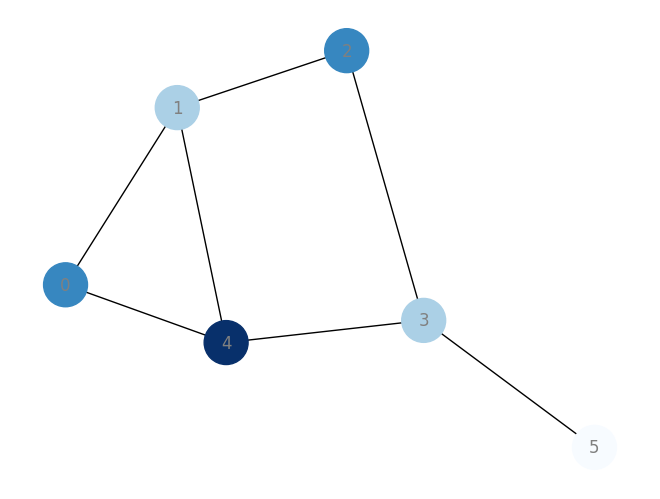

In [10]:
# Extract the node colors based on the features
node_colors = [G_example.nodes[node]["feature"] for node in G_example.nodes]

# Visualize the graph with node colors representing the features
nx.draw(G_example, with_labels=True, node_color=node_colors, cmap=plt.cm.Blues, node_size=1000, font_color='grey')
plt.show()

Now lets us mulitply adjacency matrix by node feature vector and see what we get

In [11]:
# Adjacency matrix
A_example

array([[0, 1, 0, 0, 1, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 1, 0, 1, 0, 0],
       [0, 0, 1, 0, 1, 1],
       [1, 1, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0]])

In [12]:
# Node feature vector:
feature_vector = [v for _, v in nx.get_node_attributes(G_example, "feature").items()]
feature_vector

[4, 3, 4, 3, 5, 2]

In [13]:
H = A_example @ feature_vector
H

array([ 8, 13,  6, 11, 10,  3])

The final result of this matrix multiplication is the vector of same shape as feature vector, but now each value represents the sum of features from a neighborhood for each specific node.

This is a simple implementation of message passing, where messages are feature vectors and the aggregation function is the sum.


**Now, let us ellaborate this idea and make the message passing more numerically stable and robust** 

First, let us introduce an adjacency matrix with self connections:

$\tilde{A}=A + I$

So in that way you include the information about node itself in the neighborhood aggreagtion for this node. That trick turns out to be useful for message passing.

Now let us construct degree matrix for $\tilde{A}$.

In [14]:
A_example_tilde = A_example + np.eye(A_example.shape[0])
A_example_tilde

array([[1., 1., 0., 0., 1., 0.],
       [1., 1., 1., 0., 1., 0.],
       [0., 1., 1., 1., 0., 0.],
       [0., 0., 1., 1., 1., 1.],
       [1., 1., 0., 1., 1., 0.],
       [0., 0., 0., 1., 0., 1.]])

So we can see that the diagonal of the matrix is now filled with ones.

Second, we should construct the degree matrix for $\tilde{A}$.

In [15]:
D = np.zeros_like(A_example_tilde)
np.fill_diagonal(D, A_example_tilde.sum(axis=1))
D

array([[3., 0., 0., 0., 0., 0.],
       [0., 4., 0., 0., 0., 0.],
       [0., 0., 3., 0., 0., 0.],
       [0., 0., 0., 4., 0., 0.],
       [0., 0., 0., 0., 4., 0.],
       [0., 0., 0., 0., 0., 2.]])

One can see that matrix $D$ contains degree for each node according to $\tilde{A}$.

Finally, we can combine all together and get **Normalized Adjacency Matrix**.

In [16]:
# D_inv_root[i,i] = 1 / sqrt(D[i,i])
D_inv_root = np.linalg.inv(np.sqrt(D))

A_hat = D_inv_root @ A_example_tilde @ D_inv_root
A_hat

array([[0.33333333, 0.28867513, 0.        , 0.        , 0.28867513,
        0.        ],
       [0.28867513, 0.25      , 0.28867513, 0.        , 0.25      ,
        0.        ],
       [0.        , 0.28867513, 0.33333333, 0.28867513, 0.        ,
        0.        ],
       [0.        , 0.        , 0.28867513, 0.25      , 0.25      ,
        0.35355339],
       [0.28867513, 0.25      , 0.        , 0.25      , 0.25      ,
        0.        ],
       [0.        , 0.        , 0.        , 0.35355339, 0.        ,
        0.5       ]])

So we get **Normalized Adjacency Matrix**:

$$\hat{A} = \tilde{D}^{-\frac{1}{2}}\tilde{A}\tilde{D}^{-\frac{1}{2}}$$
$$\hat{A}_{i,j} = \frac{\tilde{A}_{i,j}}{\sqrt{\tilde{d}_{i}\tilde{d}_{j}}}$$

In other words, we are normalizing connections from the adjacency matrix by using the degree of both the source and destination nodes, including self-connections. 

And now, our formula for message passing can be rewrited as:

$$H^{(l+1)} = \hat{A}H^{l}$$

where $H$ is a message.

## 3. Graph Convolution Layer

Now, as we prepared the data and found out how GCN works, we can implement it from scratch! 

Let's examine the provided **GCN Layer class**:

In [17]:
from igraph.layers import CachedCustomLayer  # base class which provides caching functionality


class GCNLayer(CachedCustomLayer):
    """
    Graph Convolutional Network Layer
    """

    def __init__(self, n_features: int, n_outputs: int):
        # To initialize our layer, we only need two arguments:
        #   1. n_features - number of features for each node in input
        #   2. n_outputs  - number of outputs for each node  in output
        self.n_features = n_features
        self.n_outputs = n_outputs

        # Here we use Xavier(Glorot) Initialization for our weights
        # It helps to converge faster. You can read about it in the original paper
        # https://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf
        sd = np.sqrt(6.0 / (n_features + n_outputs))
        self.W = np.random.uniform(-sd, sd, size=(n_outputs, n_features))

    def forward(self, adj_matrix: np.ndarray, batch: np.ndarray) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        adj_matrix is (bs, bs) adjacency matrix
        batch is (bs, D),

        where bs = "batch size" and D = input feature length
        """

        # Here we are doing message passing as described in section 2 of this tutorial
        features = (adj_matrix @ batch).T  # for calculating gradients (D, bs)

        # After message passing, the output is calculated by multiplying the features and weights
        output = (self.W @ features).T  # (bs, hs)
        return features, adj_matrix, output

    def backward(self, grad: np.ndarray, cached: tuple[np.ndarray, np.ndarray, np.ndarray],
                 lr: float = None) -> np.ndarray:
        """
        grad is upstream gradient from previous layers
        
        from cached we extract our features, adjacency matrix and output
        """
        features, adj_matrix, output = cached
        batch_size = output.shape[0]

        # Calculating the gradients for weights
        w_grad = np.asarray(grad.T @ features.T) / batch_size  # (out_dim, bs) * (bs, D) -> (out_dim, D)

        # Updating our weights using Gradient Descent, with specified learning rate
        self.W -= w_grad * lr

        # Calculating downstream gradient
        return adj_matrix @ grad @ self.W  # (bs, bs)*(bs, out_dim)*(out_dim, in_dim) = (bs, in_dim)

    def __call__(self, adj_matrix: np.ndarray, batch: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        # Calling forward method + saving its outputs in cache for backward propagation
        self.cache = self.forward(adj_matrix, batch)
        return self.cache[-1]

## 4. Graph Neural Network

To test our model and show how it works, we will solve node classification task. Having only the graph structure, model should classify the nodes in two classes: Mr.Hi and Officer.

Except the GCN Layer, we need Linear Layer and Activation Functions. Those we will use from our own library **igraph**. It consists of some default ML tools for model building, written from scratch on numpy.

In [18]:
from igraph.models import Sequential
from igraph.layers import Linear, SoftMax, Tanh, GCNLayer

# Sequential Model performs forward and backward propagation through all layers, just as in PyTorch.
# The learning rate is specified here, because we perform the weights update during backward propagation in each layer separately.
model = Sequential(lr=0.01, layers=[
    GCNLayer(n_features=A.shape[0], n_outputs=16),
    Tanh(),
    GCNLayer(n_features=16, n_outputs=16),
    Tanh(),
    GCNLayer(n_features=16, n_outputs=2),
    Tanh(),
    Linear(in_dim=2, out_dim=2),
    SoftMax()
])

Our GNN will use Graph Convolution to obtain the embeddings for each node, from the graph structure. After three convolutional layers, linear layer with softmax is used to compute class probabilities.

Here is the summary of model architecture:

**Adjacency Matrix + Feature Matrix**
|
**GCNLayer**: input_size=(bs, 34), output_size=(bs, 16)
**Tanh**: input_size=output_size=(bs, 16)
|
**GCNLayer**: input_size=(bs, 16), output_size=(bs, 16)
**Tanh**: input_size=output_size=(bs, 16)
|
**GCNLayer**: input_size=(bs, 16), output_size=(bs, 2)
**Tanh**: input_size=output_size=(bs, 2)
|
**Linear**: input_size=(bs, 2), output_size=(bs, 2)
**Softmax**: input_size=output_size=(bs, 2)
|
**Probabilities for each class**

## 5. Training Loop

Again, loading the graph, to ensure that we train on right data

In [19]:
from igraph.preprocessing import matrix_factorization

# Load the graph
G = nx.karate_club_graph()
A = nx.to_numpy_array(G)

# Normalize the adjacency matrix
A_hat = matrix_factorization(A)

As described in section 1, each node has one of the labels ['Mr. Hi', 'Officer']. We will denote 'Mr. Hi' as 0 and 'Officer' as 1.

In [20]:
y = np.array([G.nodes[i]['club'] == 'Officer' for i in G.nodes()]).astype(int)
y = np.eye(2)[y]  # 'one-hot labeling' for classes

Our feature matrix will be just the identity matrix, as we don't have any node features.

In [21]:
X = np.eye(A.shape[0])

In [22]:
epochs = 15000
log_interval = 1000
early_stopping_patience = 200  # number of epochs to wait before stopping if loss start to increase

In [23]:
from igraph.losses import cross_entropy_loss

min_loss = np.inf
patience = 0
losses = []

for epoch in range(epochs):

    # Forward propagation
    output = model(X, adj_matrix=A_hat)

    # Calculating the CrossEntropy loss
    loss = cross_entropy_loss(y, output)
    losses.append(loss)

    # Calculating the loss gradient
    grad = (output - y) / y.shape[0]  # (bs, out_dim)

    # Backward propagation
    # Note: here we don't need zero_grad as in PyTorch, because gradients are assigned, not summed up
    model.backward(grad)

    # Logging
    if epoch % log_interval == 0:
        print(f'Epoch: {epoch + 1},\tLoss: {loss.item()}')

    # Counting number of epochs when loss is greater than global minimum
    if loss < min_loss:
        min_loss = loss
        patience = 0
    else:
        patience += 1

    # Early Stopping
    if patience == early_stopping_patience:
        print(f'Early stopping at epoch {epoch + 1}')
        break

Epoch: 1,	Loss: 0.34274627358301246
Epoch: 1001,	Loss: 0.34111834970572896
Epoch: 2001,	Loss: 0.3393609687677448
Epoch: 3001,	Loss: 0.3372580876885245
Epoch: 4001,	Loss: 0.33469482854016575
Epoch: 5001,	Loss: 0.3315564050415191
Epoch: 6001,	Loss: 0.32774622023354466
Epoch: 7001,	Loss: 0.32322182191982857
Epoch: 8001,	Loss: 0.3180502197733427
Epoch: 9001,	Loss: 0.3124737776985384
Epoch: 10001,	Loss: 0.3069766627448938
Epoch: 11001,	Loss: 0.3023765116351128
Epoch: 12001,	Loss: 0.29947540907657755
Early stopping at epoch 12679


Let's plot the loss values on each epoch to ensure the model is not overfitting and everything works fine.

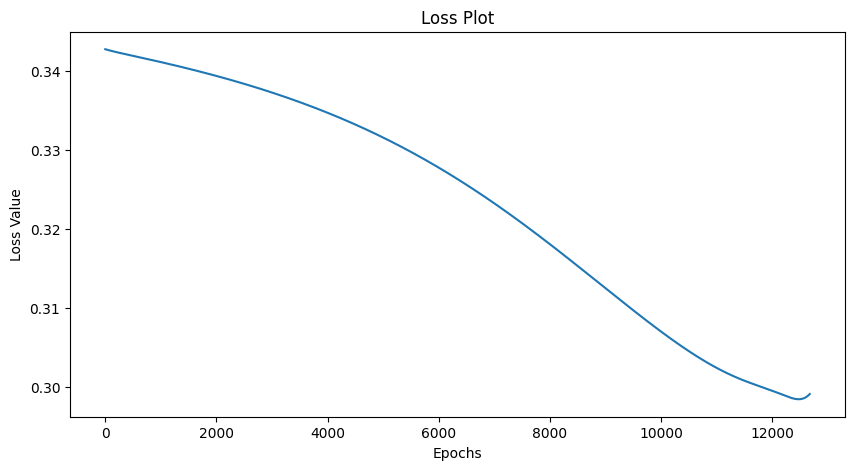

In [24]:
plt.figure(figsize=(10, 5))
plt.title("Loss Plot")
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.plot(range(epoch + 1), losses)

plt.show()

## 6. Evaluation 

For evaluation, we will predict the labels for each node in the graph and compute the accuracy.

In [25]:
def accuracy(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    This function calculates the accuracy of the model.

    :param y_true: true labels
    :param y_pred: predicted labels
    :return: accuracy
    """

    return np.mean(np.argmax(y_true, axis=1) == np.argmax(y_pred, axis=1))

In [26]:
def test(model,
         A_hat: np.ndarray, X: np.ndarray, y: np.ndarray,
         loss_fn) -> tuple[float, float]:
    """
    This function tests the model on the given data.

    :param model: igraph model
    :param A_hat: normalized adjacency matrix of the graph from A_hat = D^-1/2 * A_mod * D^-1/2, where A_mod = A + I
    :param X: feature matrix
    :param y: label matrix
    :param loss_fn: igraph loss function
    :return: loss value and accuracy
    """

    output = model(X, adj_matrix=A_hat)

    loss = loss_fn(y, output)
    acc = accuracy(y, output)

    return loss, acc

In [27]:
test_loss, test_acc = test(model, A_hat, X, y, cross_entropy_loss)

In [28]:
print(f"Test loss: {test_loss}, Test Accuracy: {test_acc}")

Test loss: 0.29907148078636986, Test Accuracy: 0.8235294117647058
